In [1]:
# Group Assignment Multivariate Econometrics Fall 2020

In [88]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
%matplotlib inline
import numpy as np

from matplotlib import pyplot as plt
from statsmodels.tsa.vector_ar.vecm import *
import pandas

In [2]:
#plt.style.use('/home/luuk/Documents/MNRAS_Style.mplstyle')

In [ ]:
# Read in the Excel file with the data
df = pd.read_excel('./MVE_assignment_2020_dataset.xlsx')
countries = ['Netherlands','Norway', 'Thailand', 'South Africa']
# Select from df only those for our countries
df = df[df['cntry.name'].apply(lambda x: x in countries)]
# Drop columns that are irrelevant (ISO names of countries)
df = df.drop(['ISO_N3','ISO_C3'],axis=1)
# Set index to increase readability
df.columns = ['Country','Year','Precipitation','Radiation','Average Temp','GDP','GDP per Capita','Population','Land','CPI']
df = df.set_index(['Country','Year'])
# Replace '..' with nans to avoid problems
df = df.replace('..',np.nan)

Precipitation   Radiation  Average Temp           GDP  \
Country     Year                                                          
Norway      1961     106.252522   98.611527      5.138921  8.817302e+10   
            1962     105.679911   98.198011      3.581438  9.065416e+10   
            1963      93.200713   99.278966      3.683132  9.408546e+10   
            1964     108.295234   99.661060      4.379773  9.879881e+10   
            1965      90.866410   98.732373      3.589041  1.040000e+11   
...                         ...         ...           ...           ...   
Netherlands 2015      68.869257  120.634657     10.826177  8.790000e+11   
            2016      65.496914  117.348070     10.650305  8.980000e+11   
            2017      71.151452  119.267300     10.884695  9.240000e+11   
            2018      53.223042  131.562959     11.350704  9.480000e+11   
            2019      67.655106  124.144886     11.229953  9.650000e+11   

                  GDP per Capita  Population     Land     CPI  
Country     Year                                               
Norway      1961     24426.01143   3609800.0  10340.0  122.58  
            1962     24912.39328   3638918.0  10310.0  100.12  
            1963     25660.57706   3666537.0  10280.0  125.17  
            1964     26743.29783   3694339.0  10190.0   99.35  
            1965     27938.82163   3723168.0  10110.0  116.48  
...                          ...         ...      ...     ...  
Netherlands 2015     51871.57650  16939923.0  18370.0  108.77  
            2016     52727.10248  17030314.0  17960.0  106.52  
            2017     53942.08509  17131296.0      NaN     NaN  
            2018     55020.97997  17231624.0      NaN     NaN  
            2019     55689.98946  17332850.0      NaN     NaN  

[236 rows x 8 columns]

In [31]:
#df = df[['Precipitation','Radiation','Average Temp','GDP per Capita','CPI']]

In [32]:
lag_order = select_order(data=df.dropna(), maxlags=10, deterministic="ci", seasons=4)
lag_order.summary()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/luuk/anaconda3/lib/pyt

,AIC,BIC,FPE,HQIC
0,81.85,82.63*,3.537e+35,82.17*
1,81.77*,82.94,3.244e+35*,82.24
2,81.84,83.40,3.495e+35,82.47
3,81.90,83.86,3.737e+35,82.69
4,81.99,84.33,4.070e+35,82.93
5,82.10,84.83,4.576e+35,83.20
6,82.21,85.34,5.168e+35,83.47
7,82.31,85.82,5.739e+35,83.73
8,82.41,86.31,6.427e+35,83.99
9,82.55,86.85,7.541e+35,84.29


In [33]:
print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 0, FPE -> 1, HQIC -> 0>


In [34]:
corr_NO = df.loc['Norway'].corr()
corr_TH = df.loc['Thailand'].corr()
corr_SA = df.loc['South Africa'].corr()
corr_NL = df.loc['Netherlands'].corr()

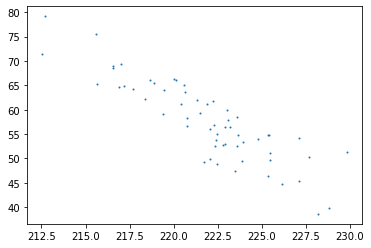

In [18]:
plt.scatter(df.loc['South Africa'].Radiation,df.loc['South Africa'].Precipitation,s=1)

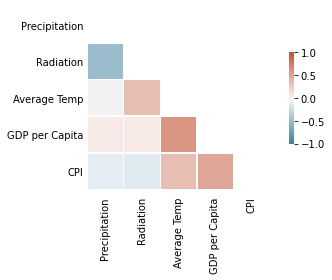

In [35]:
corr_mat = 0
for i,country in enumerate(countries):
    try:
        corr_mat += df.loc[country].corr()
    except:
        corr_mat = df.loc[country].corr()
    
corr = corr_mat/4
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
ax.tick_params(axis='x', which='major', bottom=False, top=False)
ax.tick_params(axis='y', which='minor', length=0)
ax.tick_params(axis='y', which='major', length=0)
plt.tight_layout()
plt.savefig('Correlogram.pdf')

In [36]:
# Available data:
# Mean precipitation
# Mean radiation
# Average yearly temperaure
# GDP
# GDP per capita
# Population, total
# Agricultural land
# Crop production index

KeyError: 'GDP'

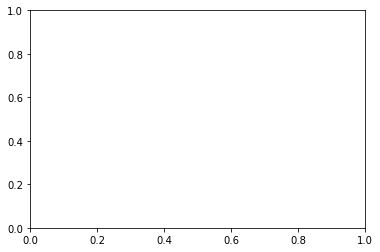

In [37]:
class simple_figures():
    def __init__(self):
        self.df = df
    
    def GPD_Growth(self):
        fig, ax = plt.subplots()
        GDP_Growth = df['GDP'].unstack().T.pct_change()*100
        ax.bar(GDP_Growth.index,GDP_Growth.Netherlands,label='Netherlands',alpha=1)
        ax.bar(GDP_Growth.index,GDP_Growth.Norway, label='Norway',alpha=0.7,color='red')

        ax.set_xlabel('Year')
        ax.set_ylabel('YtY GDP Growth (\%)')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
    def GPDpC_Growth(self):
        fig, ax = plt.subplots()
        GDP_Growth = df['GDP per Capita'].unstack().T.pct_change()*100
        ax.bar(GDP_Growth.index,GDP_Growth.Netherlands,label='Netherlands',alpha=1)
        ax.bar(GDP_Growth.index,GDP_Growth.Norway, label='Norway',alpha=0.7, color='red')

        ax.set_xlabel('Year')
        ax.set_ylabel('YtY GDP per Capita Growth (\%)')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        
        
figs = simple_figures()
figs.GPD_Growth()
figs.GPDpC_Growth()

In [39]:
class preprocessing():
    def __init__(self):
        self.demean()
        self.stationary(df)
        self.detrend()
        return
        
    def demean(self):
        """Group by country and subtract mean of each column
           from the data. This will enhance the visibility of 
           outliers"""
        self.demeaned = df  - df.groupby('Country').mean()
        
    def loglevels(self):
        """Simply take the logarithm of all levels"""
        self.log = np.log(df)
        
    def stationary(self,df):
        """To detrend the data we check for each timeseries
           if it is stationary or not. This function returns 
           for each country and column the p value for the ADF
           test"""
        stationary_results = pd.DataFrame()
        lags_results = pd.DataFrame()
        for country in countries:
            # loop through countries
            subdf = df.loc[country]
            for col in subdf.columns:
                # Run ADF test to check for stationarity
                ADF_p = adfuller(subdf[col].dropna())[1]
                lagsused = adfuller(subdf[col].dropna())[2]
                stationary_results.loc[country,col] = ADF_p
                lags_results.loc[country,col] = lagsused
        self.stationary_results = stationary_results
        self.lags = lags_results
        # Low p values are stationary
        self.isstationary = stationary_results<0.05
        
    def detrend(self):
        """If it is not stationary we should take the difference 
           sequence. If time series is stationary, we can keep the
           original"""
        # The non-stationary timeseries are detrended by taking diff series
        not_stationary = ['Average Temp','GDP','GDP per Capita',
                          'Population','Land','CPI']
        self.detrended = df.copy()
        for col in not_stationary:
            self.detrended[col+'_detrended'] = df[col].unstack().T.diff().T.stack()
        return

#preprocessed = preprocessing()
#preprocessed.isstationary
#preprocessed.detrended['GDP_detrended'].values
#preprocessed.detrended.loc['Netherlands'].Land_detrended.plot()
#print(preprocessed.lags.astype(int).to_latex())

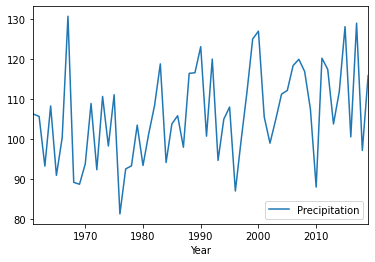

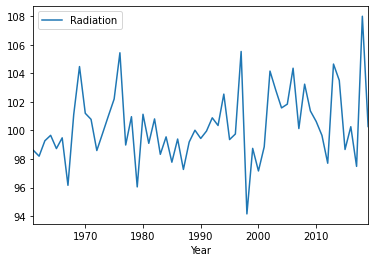

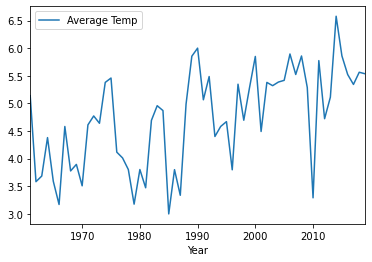

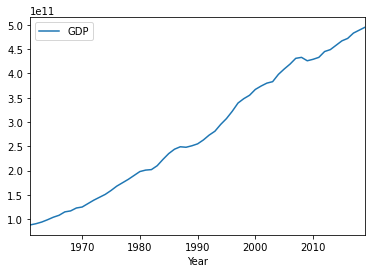

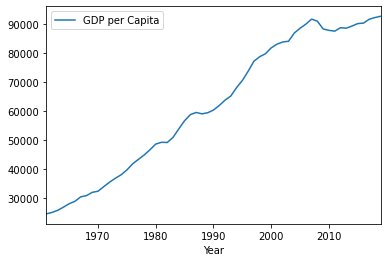

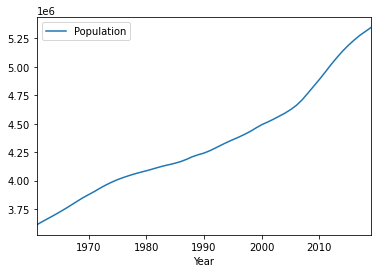

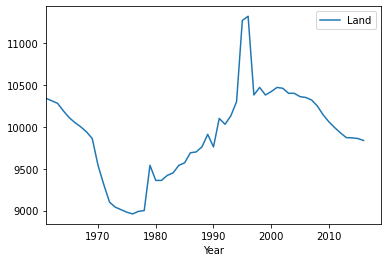

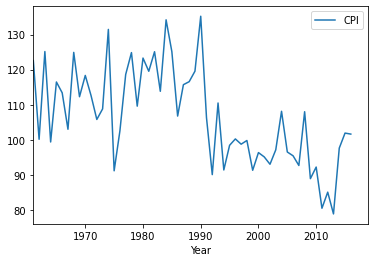

In [8]:
# Preprocessing
df.loc['Norway'].reset_index().plot(x='Year',y='Precipitation')
df.loc['Norway'].reset_index().plot(x='Year',y='Radiation')
df.loc['Norway'].reset_index().plot(x='Year',y='Average Temp')
df.loc['Norway'].reset_index().plot(x='Year',y='GDP')
df.loc['Norway'].reset_index().plot(x='Year',y='GDP per Capita')
df.loc['Norway'].reset_index().plot(x='Year',y='Population')
df.loc['Norway'].reset_index().plot(x='Year',y='Land')
df.loc['Norway'].reset_index().plot(x='Year',y='CPI')

In [40]:
sns.pairplot(preprocessed.detrended.loc['Norway'].reset_index().dropna(),corner=True)
plt.show()

KeyboardInterrupt: 

<h3>Analysis of the order of integration</h3>

In [41]:
# As before, we first apply a simple DF test to identify stationarity
stationary_results = pd.DataFrame()
for country in countries:
    # loop through countries
    subdf = df.loc[country]
    for col in subdf.columns:
        # Run ADF test to check for stationarity
        ADF_p = adfuller(subdf[col].dropna())[1]
        stationary_results.loc[country,col] = ADF_p
stationary_results = stationary_results
# Low p values are stationary
isstationary = stationary_results<0.05
isstationary = isstationary.T
isstationary

,Netherlands,Norway,Thailand,South Africa
Precipitation,True,True,True,True
Radiation,True,True,False,True
Average Temp,True,False,False,False
GDP per Capita,False,False,True,False
CPI,False,False,False,False


In [42]:
# Order of integration: 
# which difference series make the series stationary?

Time series processes whose $d^{th}$ difference have a stationary, invertible ARMA(p,q) representation are called integrated processes of order $d$, $I(d)$. The corresponding representation

$$\alpha (L) \Delta^d x_t = \mu + \theta(L) \epsilon_t$$

This representation is called the ARIMA(p,d,q) model

In [43]:
# Thus for each non stationary series we test order 1,2 and 3 difference sequence

In [44]:
def delta_operator(x):
    return np.diff(x)
x = np.arange(0,10,1)

In [65]:
integratability = pd.DataFrame()
lags = pd.DataFrame()
for country in countries:
    # loop through countries
    subdf = df.loc[country]
    for col in subdf.columns:
        timeseries = subdf[col].dropna()
        # Run ADF test to check for stationarity on original series
        ADF_c_p = adfuller(timeseries, regression='c')[1]
        ADF_ct_p = adfuller(timeseries, regression='ct')[1]
        ADF_nc_p = adfuller(timeseries, regression='nc')[1]

        KPSS_p = kpss(timeseries,nlags='auto')[1]
        integratability = integratability.append({'Country': country, 
                                                      'OoI': 0, 
                                                      'Series':col,
                                                      'pval_ADF_c': ADF_c_p<0.05,
                                                      'pval_ADF_ct': ADF_ct_p<0.05,
                                                      'pval_ADF_nc': ADF_nc_p<0.05,
                                                      'pval_KPSS': KPSS_p>0.05}, ignore_index=True)
        lags = lags.append({'Country': country, 
                            'OoI': 0, 
                            'Series':col,'lagsKPSS':kpss(timeseries,nlags='auto')[2],'lagsADF':adfuller(timeseries, regression='c')[2]},ignore_index=True)
        # Take dth difference sequence (1,2,3)
        for OoI in [1,2,3]:
            timeseries = delta_operator(timeseries)
            ADF_c_p = adfuller(timeseries, regression='c')[1]
            ADF_ct_p = adfuller(timeseries, regression='ct')[1]
            ADF_nc_p = adfuller(timeseries, regression='nc')[1]
            KPSS_p = kpss(timeseries)[1]
            # For each diff series we test obtain ADF pvalue for stationarity
            integratability = integratability.append({'Country': country, 
                                                      'OoI': OoI, 
                                                      'Series':col,
                                                      'pval_ADF_c': ADF_c_p<0.05,
                                                      'pval_ADF_ct': ADF_ct_p<0.05,
                                                      'pval_ADF_nc': ADF_nc_p<0.05,
                                                      'pval_KPSS': KPSS_p>0.05}, ignore_index=True)
integratability = integratability.set_index(['Country','OoI','Series']).unstack()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:16

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:16

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:16

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:16

In [75]:
lags.set_index(['Country','Series']).max(axis=1).unstack()[df.columns]

Series,Precipitation,Radiation,Average Temp,GDP,GDP per Capita,Population,Land,CPI
Country,,,,,,,,
Netherlands,0.0,3.0,4.0,4.0,4.0,10.0,4.0,4.0
Norway,2.0,2.0,5.0,4.0,4.0,7.0,4.0,4.0
South Africa,3.0,3.0,5.0,4.0,4.0,11.0,6.0,4.0
Thailand,1.0,4.0,3.0,4.0,8.0,4.0,4.0,4.0


In [27]:
(integratability.loc['Norway']).T.astype(bool)

OoI                           0.0    1.0   2.0    3.0
            Series                                   
pval_ADF_c  Average Temp    False   True  True   True
            CPI             False   True  True   True
            GDP             False   True  True   True
            GDP per Capita  False   True  True   True
            Land            False   True  True   True
            Population      False  False  True   True
            Precipitation    True   True  True   True
            Radiation        True   True  True   True
pval_ADF_ct Average Temp     True   True  True   True
            CPI              True   True  True   True
            GDP             False   True  True   True
            GDP per Capita  False   True  True   True
            Land            False   True  True   True
            Population      False  False  True  False
            Precipitation    True   True  True   True
            Radiation        True   True  True   True
pval_ADF_nc Average Temp    False   True  True   True
            CPI             False   True  True   True
            GDP             False  False  True   True
            GDP per Capita  False   True  True   True
            Land            False   True  True   True
            Population      False  False  True   True
            Precipitation   False   True  True   True
            Radiation       False   True  True   True
pval_KPSS   Average Temp    False   True  True   True
            CPI             False   True  True   True
            GDP             False   True  True   True
            GDP per Capita  False   True  True   True
            Land             True   True  True   True
            Population      False   True  True   True
            Precipitation   False   True  True   True
            Radiation        True   True  True   True

<h3>Make figures</h3>

In [90]:
from astropy.io import ascii
df = ascii.read('./data_CO2').to_pandas()

In [91]:
df.columns=['Year','CO2_excess']

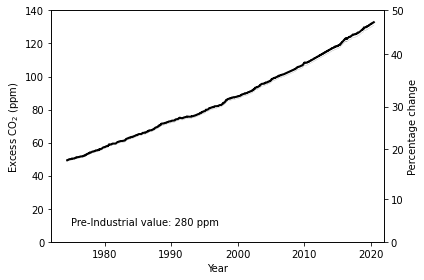

In [96]:
fig,ax = plt.subplots()
ax.plot(df.Year, df.CO2_excess,color='black',lw=2)
ax.set_xlabel('Year')
ax.set_ylabel(r'Excess CO$_2$ (ppm)')
ax.set_ylim(0,140)
ax.set_xlim(1972,2022)
plt.annotate("Pre-Industrial value: 280 ppm",xy=(1975,10))
ax2 = ax.twinx()
ax2.plot(df.Year, df.CO2_excess,color='black',lw=0.1)
ax2.set_ylim(0,140)
ticks = ax.get_yticks()
ax2.set_yticks([0,26,57,83,115,142])
ax2.set_yticklabels([0,10,20,30,40,50])
ax2.set_ylabel('Percentage change')
ax2.grid(False)
ax1.grid(False)
ax.grid(False)
plt.tight_layout()

plt.savefig('ExcessCO2.pdf')

In [97]:
df = ascii.read('./HadCRUT.4.6.0.0.annual_ns_avg.txt').to_pandas()
df2 = ascii.read('./GLB.Ts+dSST.txt').to_pandas()
df3=pd.read_csv('1880-2019.csv')
df3

,Year,Value
0,1880,-0.12
1,1881,-0.09
2,1882,-0.10
3,1883,-0.18
4,1884,-0.27
...,...,...
135,2015,0.93
136,2016,1.00
137,2017,0.91
138,2018,0.83


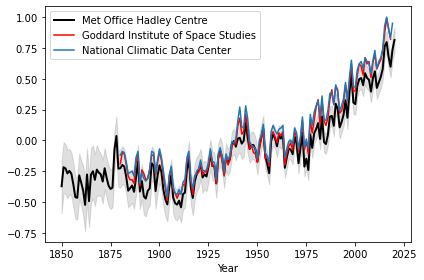

In [100]:
fig,ax = plt.subplots()
ax.plot(df.col1, df.col2,color='black',lw=2,label='Met Office Hadley Centre')
ax.plot(df2.col20.iloc[1:-1].astype(float).values,df2.col14.iloc[1:-1].astype(float).values/100,label='Goddard Institute of Space Studies',color='red')
ax.plot(df3.Year, df3.Value,label='National Climatic Data Center')
ax.set_xlabel('Year')
ax.fill_between(df.col1, df.col11,df.col12,color='grey',alpha=0.25)
#ax.set_ylabel(r'Excess CO$_2$ (ppm)')
#ax.set_ylim(0,140)
#ax.set_xlim(1972,2022)
#plt.annotate("Pre-Industrial value: 280 ppm",xy=(1975,10))
plt.legend()
plt.tight_layout()
plt.savefig('Temp_increase.pdf')

KeyError: 'Netherlands'

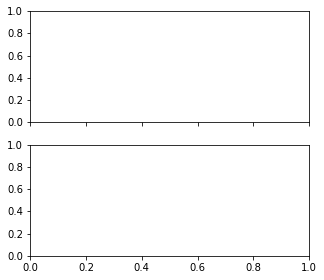

In [102]:
fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(5,4.5),sharex=True)
for country in countries:
    normed_GDP = df.loc[country]['GDP per Capita'] / df.loc[country]['GDP per Capita'].loc[1961]*100
    ax1.plot(df.loc[country].index, normed_GDP,label=country)
ax1.set_ylabel('GDP pC (1961=100%)')
ax1.set_ylim(75,400)
ax1.legend()    
for country in countries:
    normed_pop = df.loc[country]['Population'] / df.loc[country]['Population'].loc[1961]*100
    ax2.plot(df.loc[country].index, normed_pop,label=country)
ax2.set_ylabel('Population (1961=100%)')
ax2.set_xlabel('Year')
ax2.set_ylim(85,349)
plt.tight_layout(pad=-0.5)

#plt.savefig('GDP_Population_Growth.pdf',bbox_inches='tight')

(40.0, 160.0)

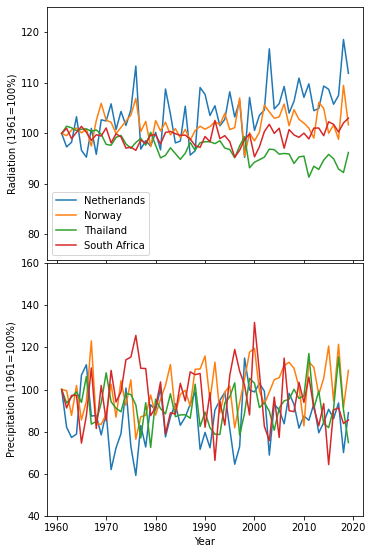

In [84]:
fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(5,7.3),sharex=True)
for country in countries:
    normed_GDP = df.loc[country]['Radiation'] / df.loc[country]['Radiation'].loc[1961]*100
    ax1.plot(df.loc[country].index, normed_GDP,label=country)
ax1.set_ylabel('Radiation (1961=100%)')
ax1.set_ylim(75,125)
ax1.legend()    
for country in countries:
    normed_pop = df.loc[country]['Precipitation'] / df.loc[country]['Precipitation'].loc[1961]*100
    ax2.plot(df.loc[country].index, normed_pop,label=country)
ax2.set_ylabel('Precipitation (1961=100%)')
plt.tight_layout(pad=0)
ax2.set_xlabel('Year')
ax2.set_ylim(40,160)
#plt.savefig('GDP_Population_Growth.pdf')

In [47]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)



In [48]:
adf_test(df.loc['Norway']['Precipitation'])

kpss_test(df.loc['Norway']['Precipitation'])

Results of Dickey-Fuller Test:
Test Statistic                -7.011918e+00
p-value                        6.886737e-10
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64
Results of KPSS Test:
Test Statistic           0.824674
p-value                  0.010000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [49]:
print(adfuller(df.loc['Norway']['Precipitation'],regression = 'c')[1])
print(adfuller(df.loc['Norway']['Precipitation'],regression = 'ct')[1])
print(adfuller(df.loc['Norway']['Precipitation'],regression = 'nc')[1])

6.88673694336291e-10
1.92755298431946e-11
0.8489276296428533


In [60]:
print(adfuller(df.loc['Netherlands']['Precipitation'],regression = 'c')[1])
print(adfuller(df.loc['Netherlands']['Precipitation'],regression = 'ct')[1])
print(adfuller(df.loc['Netherlands']['Precipitation'],regression = 'nc')[1])

2.4842757038791176e-08
3.5009016324789816e-07
0.5108046214516685


In [61]:
print(adfuller(df.loc['Thailand']['Precipitation'],regression = 'c')[1])
print(adfuller(df.loc['Thailand']['Precipitation'],regression = 'ct')[1])
print(adfuller(df.loc['Thailand']['Precipitation'],regression = 'nc')[1])

4.9475641568622464e-09
1.1431571471034737e-07
0.45920050235038334


In [62]:
print(adfuller(df.loc['South Africa']['Precipitation'],regression = 'c')[1])
print(adfuller(df.loc['South Africa']['Precipitation'],regression = 'ct')[1])
print(adfuller(df.loc['South Africa']['Precipitation'],regression = 'nc')[1])

2.189270375714459e-08
1.7290506544751244e-07
0.49981613513559336


In [53]:
startval = 0
values = np.zeros(int(1e5))
epsilon = np.random.randn(int(1e5))*0.5
for i in range(len(values)-1):
    values[i+1] = 0.910*values[i] + epsilon[i]

In [55]:
adfuller(values)

(-55.795747549663986,
 0.0,
 9,
 99990,
 {'1%': -3.430415401218969,
  '5%': -2.861568906314114,
  '10%': -2.56678538581951},
 144705.21020720975)

In [40]:
from matplotlib import cm
cmap = cm.get_cmap('Accent',8)
cmap = cmap(np.arange(0,8))

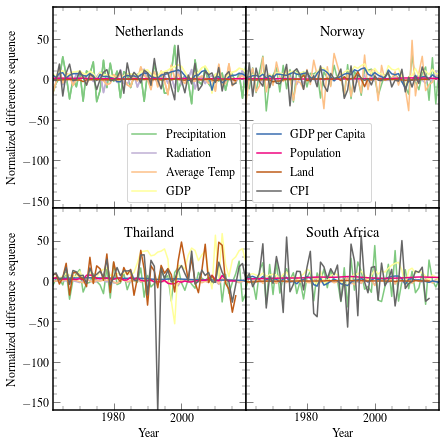

In [42]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(6,6))
for ax_iter,country in enumerate(countries):
    ax = [ax1,ax2,ax3,ax4][ax_iter]
    for col_iter,col in enumerate(df.columns):
        normed = np.diff(df.loc[country][col] / df.loc[country][col].loc[1961]*100)
        if (col_iter<4)&(ax_iter==0):
            ax.plot(df.loc[country].index.values[1:], normed,color=cmap[col_iter],label=col)
        if (col_iter>=4)&(ax_iter==1):
            ax.plot(df.loc[country].index.values[1:], normed,color=cmap[col_iter],label=col)

        else:
            ax.plot(df.loc[country].index.values[1:], normed,color=cmap[col_iter])    
    ax.set_title(country,x=0.5,y=0.83)
    ax.set_ylim(-160,90)
    ax.grid(False)

ax3.set_xlabel('Year')
ax4.set_xlabel('Year')
ax1.legend(loc='lower right')
ax2.legend(loc='lower left')
ax1.set_ylabel('Normalized difference sequence')
ax3.set_ylabel('Normalized difference sequence')
plt.tight_layout(pad=0)
plt.grid(False)
plt.savefig('Outlier_detection.pdf')

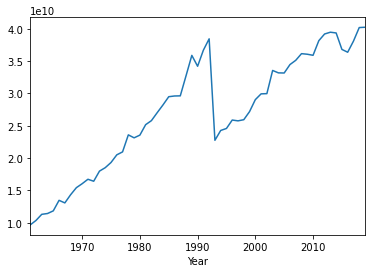

In [27]:
df.loc['Thailand']['CPI'].plot()

In [28]:
df

Precipitation   Radiation  Average Temp           GDP  \
Country     Year                                                          
Norway      1961     106.252522   98.611527      5.138921  8.817302e+10   
            1962     105.679911   98.198011      3.581438  9.065416e+10   
            1963      93.200713   99.278966      3.683132  9.408546e+10   
            1964     108.295234   99.661060      4.379773  9.879881e+10   
            1965      90.866410   98.732373      3.589041  1.040000e+11   
...                         ...         ...           ...           ...   
Netherlands 2015      68.869257  120.634657     10.826177  8.790000e+11   
            2016      65.496914  117.348070     10.650305  8.980000e+11   
            2017      71.151452  119.267300     10.884695  9.240000e+11   
            2018      53.223042  131.562959     11.350704  9.480000e+11   
            2019      67.655106  124.144886     11.229953  9.650000e+11   

                  GDP per Capita  Population     Land     CPI  
Country     Year                                               
Norway      1961     24426.01143   3609800.0  10340.0  122.58  
            1962     24912.39328   3638918.0  10310.0  100.12  
            1963     25660.57706   3666537.0  10280.0  125.17  
            1964     26743.29783   3694339.0  10190.0   99.35  
            1965     27938.82163   3723168.0  10110.0  116.48  
...                          ...         ...      ...     ...  
Netherlands 2015     51871.57650  16939923.0  18370.0  108.77  
            2016     52727.10248  17030314.0  17960.0  106.52  
            2017     53942.08509  17131296.0      NaN     NaN  
            2018     55020.97997  17231624.0      NaN     NaN  
            2019     55689.98946  17332850.0      NaN     NaN  

[236 rows x 8 columns]

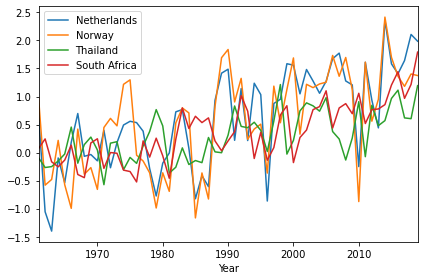

In [86]:
fig,ax = plt.subplots()
(df.loc['Netherlands']['Average Temp'] - df.loc['Netherlands'].iloc[:25]['Average Temp'].mean()).plot(label='Netherlands')
(df.loc['Norway']['Average Temp'] - df.loc['Norway'].iloc[:25]['Average Temp'].mean()).plot(label='Norway')
(df.loc['Thailand']['Average Temp'] - df.loc['Thailand'].iloc[:25]['Average Temp'].mean()).plot(label='Thailand')
(df.loc['South Africa']['Average Temp'] - df.loc['South Africa'].iloc[:25]['Average Temp'].mean()).plot(label='South Africa')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('TempIncrease4countries.pdf',bbox_inches='tight')

In [30]:
(df.loc['Netherlands']['Average Temp'] - df.loc['Netherlands'].iloc[:25]['Average Temp'].mean()).iloc[-10:].mean()
(df.loc['Norway']['Average Temp'] - df.loc['Norway'].iloc[:25]['Average Temp'].mean()).iloc[-10:].mean()
(df.loc['Thailand']['Average Temp'] - df.loc['Thailand'].iloc[:25]['Average Temp'].mean()).iloc[-10:].mean()
(df.loc['South Africa']['Average Temp'] - df.loc['South Africa'].iloc[:25]['Average Temp'].mean()).iloc[-10:].mean()

1.0596477826623676

In [33]:
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
# null hypothesis is no cointegration
result = ts.coint(df.loc['Netherlands']['GDP'], df.loc['Netherlands']['Average Temp'])[1]
result

0.8524004021301935

In [62]:
cointegrated = pd.DataFrame()
for country in countries:
    subdf = df.loc[country]
    for col1 in subdf.columns:
        for col2 in subdf.columns:
            x = subdf[col1]
            y = subdf[col2]
            isfinite = np.isfinite(x*y)
            x = x[isfinite]
            y = y[isfinite]
            if col1==col2: continue
            pval_c = ts.coint(x,y)[1]
            pval_ct = ts.coint(x,y, trend='ct')[1]
            cointegrated = cointegrated.append({'Country':country,'Variable1':col1,'Variable2':col2,'pval_c':pval_c, 'pval_ct':pval_ct}, ignore_index=True)
            

In [66]:
# four situations
# one of the two <0.05: cointegrated
# both larger: not cointegrated

In [71]:
cointegrated2 = pd.DataFrame(index=df.columns, columns=df.columns).fillna('')
for i,row in cointegrated.iterrows():
    if (row.pval_c<0.05 or row.pval_ct<0.05):
        cointegrated2.loc[row.Variable1,row.Variable2] += row.Country[:2]+' '

In [72]:
cointegrated2

,Precipitation,Radiation,Average Temp,GDP,GDP per Capita,Population,Land,CPI
Precipitation,,Ne No Th So,Ne No Th So,Ne No Th So,Ne No Th So,Ne No Th So,Ne No Th So,Ne No Th So
Radiation,Ne No Th So,,Ne No Th So,Ne No Th So,Ne No Th So,Ne No Th So,Ne No Th So,Ne No Th So
Average Temp,Ne Th So,Ne No Th So,,Ne No Th So,Ne No Th So,Ne No Th So,Ne No Th So,Ne No Th So
GDP,,,So,,,,Ne,
GDP per Capita,Ne,Ne Th,,,,,Ne,
Population,,Th,Ne So,,,,,
Land,,,Ne,Ne,Th,,,
CPI,No So,No Th So,Ne No So,No So,No So,No So,No So,


In [ ]:
df.to_excel('cointegration.xlsx')

cvm

    Critical values (90%, 95%, 99%) of maximum eigenvalue statistic.
cvt

    Critical values (90%, 95%, 99%) of trace statistic
eig

    Eigenvalues of VECM coefficient matrix
evec

    Eigenvectors of VECM coefficient matrix
ind

    Order of eigenvalues
lr1

    Trace statistic
lr2

    Maximum eigenvalue statistic
max_eig_stat

    Maximum eigenvalue statistic
max_eig_stat_crit_vals

    Critical values (90%, 95%, 99%) of maximum eigenvalue statistic.
meth

    Test method
r0t

    Residuals for ΔY

    .
rkt

    Residuals for Y−1

trace_stat

    Trace statistic
trace_stat_crit_vals

    Critical values (90%, 95%, 99%) of trace statistic


In [87]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
x = df.loc['Netherlands'].dropna()
jres = coint_johansen(x, det_order=0, k_ar_diff=2)

#5% levels
jres.trace_stat>jres.cvt[:,1]
output = pd.DataFrame({'Hypothesis (num of coint vec)':['At most '+str(w) for w in range(8)],
              'Test statistic':jres.trace_stat,
              '95% critical value':jres.cvt[:,1],
              'Reject at p=0.05':jres.trace_stat>jres.cvt[:,1]}).set_index('Hypothesis (num of coint vec)')
output.round(2)#print(output.round(2).to_latex())

,Test statistic,95% critical value,Reject at p=0.05
Hypothesis (num of coint vec),,,
At most 0,281.42,159.53,True
At most 1,203.93,125.62,True
At most 2,136.39,95.75,True
At most 3,92.09,69.82,True
At most 4,55.93,47.85,True
At most 5,24.53,29.80,False
At most 6,9.53,15.49,False
At most 7,3.99,3.84,True


In [126]:
# largest ev 0.825 
# 


In [66]:
pd.DataFrame(jres.evec,index=df.columns, columns=df.columns)

,Precipitation,Radiation,Average Temp,GDP,GDP per Capita,Population,Land,CPI
Precipitation,1.794579e-01,-2.953119e-01,3.369908e-02,1.267310e-01,7.539255e-02,4.399303e-02,7.055683e-02,-4.523519e-02
Radiation,6.541142e-01,-3.639937e-01,1.697886e-01,8.524140e-02,3.331833e-01,-1.605623e-01,3.767388e-02,-2.211981e-01
Average Temp,-1.717724e+00,1.919654e+00,5.867100e-01,2.363134e+00,-2.446475e+00,-5.501481e-01,2.664479e-02,5.347544e-01
GDP,2.930056e-11,1.059041e-10,-2.068178e-11,1.394206e-11,4.521788e-13,4.625639e-12,1.221295e-10,9.740021e-11
GDP per Capita,-1.199389e-03,-2.037564e-03,6.673996e-05,2.084978e-04,1.098687e-03,1.544942e-04,-2.758855e-03,-2.284136e-03
Population,7.596245e-06,1.926303e-06,8.130810e-06,-1.283324e-05,-1.725849e-05,1.404045e-06,6.428122e-06,3.471582e-06
Land,2.412662e-03,2.972381e-03,-1.400680e-03,-4.703821e-03,-7.122063e-03,-1.164821e-04,8.858260e-04,-2.332594e-03
CPI,-2.084939e-01,-1.014845e-01,-3.481483e-01,2.786200e-01,2.812583e-01,-2.288174e-01,-1.687816e-01,-1.517435e-01


In [82]:
matprod = np.matmul(df.loc['Netherlands'].values,jres.evec)
matprod = pd.DataFrame(matprod,columns=df.columns,index=df.loc['Netherlands'].index).dropna()

In [125]:
data = df.loc['Netherlands'].dropna()
rank_test = select_coint_rank(data, 0, 3, method="trace",
                              signif=0.05)
rank_test.rank
model = VECM(data, deterministic="ci", seasons=0,
             k_ar_diff=1,  # =3
             coint_rank=rank_test.rank)  # =1
vecm_res = model.fit()
vecm_res.summary()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


,coef,std err,z,P>|z|,[0.025,0.975]
L1.Precipitation,0.2284,0.210,1.088,0.276,-0.183,0.640
L1.Radiation,0.3770,0.403,0.937,0.349,-0.412,1.166
L1.Average Temp,3.2354,2.216,1.460,0.144,-1.108,7.579
L1.GDP,-1.305e-09,1.21e-09,-1.080,0.280,-3.67e-09,1.06e-09
L1.GDP per Capita,0.0232,0.019,1.212,0.226,-0.014,0.061
L1.Population,3e-05,7.14e-05,0.420,0.674,-0.000,0.000
L1.Land,-0.0062,0.011,-0.589,0.556,-0.027,0.014
L1.CPI,-0.1395,0.292,-0.477,0.633,-0.713,0.434
,coef,std err,z,P>|z|,[0.025,0.975]
L1.Precipitation,0.0038,0.105,0.037,0.971,-0.202,0.210


<h3>Granger Causality</h3>

In [127]:
# imports the permutation function to generate all permutations of 2 of the FANG stocks
from itertools import permutations
# imports test for Granger Causality (does variable x have value in predicting y)
from statsmodels.tsa.stattools import grangercausalitytests

In [288]:
def find_granger_causality(land):
    variables = df.columns
    data = df.loc[land]
    # creates a list of tuples containing the permutations of length 2 of the FANG stocks
    var_perms = list(permutations(variables, 2))
    granger_df = pd.DataFrame(index=variables, columns=variables)
    granger_df_sign = pd.DataFrame(index=variables, columns=variables)
    # loops through the list of stock permutations
    for i in range(len(var_perms)):
        # converts the tuple to a list so it can be passed to the dataframe for column selection
        temp_list = list(var_perms[i])
        # creates a temporary dataframe of just the two variables
        temp_df = data[temp_list].diff().dropna()
        # prints which permutation is being tested for interpretability
        #print('Does a lag of ' + temp_list[1] + ' predict ' + temp_list[0])
        # prints the results of a Granger Causality test for each permutation with 1 lage
        granger_output = grangercausalitytests(temp_df, maxlag = 1, addconst = True, verbose = False)
        beta_OLS = granger_output[1][1][0].params[0]
        # leaves two spaces for readability
        granger_df.loc[temp_list[0],temp_list[1]] = granger_output[1][0]['ssr_chi2test'][1]
        granger_df_sign.loc[temp_list[0],temp_list[1]] = beta_OLS / np.abs(beta_OLS)
    granger = (granger_df<0.05).stack()
    granger_df_sign = granger_df_sign.stack()[granger].dropna()
    granger = granger[granger].dropna()
    granger[granger] = land
    return granger, granger_df_sign


def combine_granger():
    granger_dfs = [find_granger_causality(w)[0] for w in countries]
    granger_dfs_beta = [find_granger_causality(w)[1] for w in countries]
    a = pd.DataFrame(pd.concat(granger_dfs).sort_index()).reset_index()
    #b = pd.DataFrame(pd.concat(granger_dfs_beta).sort_index()).reset_index()
    a.columns=['col1','col2','country']
    #b.columns=['col1','col2','beta_OLS']
    a=a.set_index(['col1','col2'])
    #b=b.set_index(['col1','col2'])
    
    a = pd.get_dummies(a).groupby(['col1','col2']).sum()
    #return a
    return granger_dfs_beta#print(pd.get_dummies(a).groupby(['col1','col2']).sum().to_latex())
combine_granger()

[Population  GDP               1
             GDP per Capita    1
 Land        Population       -1
 dtype: object,
 Radiation       Average Temp   -1
                 Land           -1
 GDP per Capita  GDP             1
                 Population      1
 dtype: object,
 Precipitation  Average Temp     -1
                Land             -1
                CPI              -1
 Radiation      Precipitation    -1
 Average Temp   Precipitation    -1
 GDP            GDP per Capita    1
 Population     Average Temp      1
                GDP               1
 Land           Precipitation     1
 dtype: object,
 GDP             CPI             1
 GDP per Capita  Average Temp    1
                 Population      1
                 Land            1
                 CPI             1
 Land            Population      1
 dtype: object]

<h3>VECM</h3>

In [97]:
# imports VECM for VECM modeling
from statsmodels.tsa.vector_ar.vecm import VECM

# estimates the VECM on the closing prices with 4 lags, 1 cointegrating relationship, and
# a constant within the cointegration relationship
def fit_vecm(land):
    estimate_vecm = VECM(endog = df.loc[land].dropna(), k_ar_diff =4, coint_rank = 1, deterministic = 'ci')
    estimate_vecm_fit = estimate_vecm.fit()
    estimate_vecm_fit.summary()
    return estimate_vecm_fit

def predict_vecm(land):
    estimate_vecm_fit = fit_vecm(land)
    #fig,ax=plt.subplots()
    ahead=30
    mid, lower, upper = estimate_vecm_fit.predict(ahead, alpha=0.05)
    y = estimate_vecm_fit.y_all.T
    n_last_obs = None
    y = y[estimate_vecm_fit.k_ar:] if n_last_obs is None else y[-n_last_obs:]
    plot_var_forc(y, mid, lower, upper,ahead, names=df.columns,
                       plot_stderr=True,
                       legend_options={"loc": "lower left"})

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


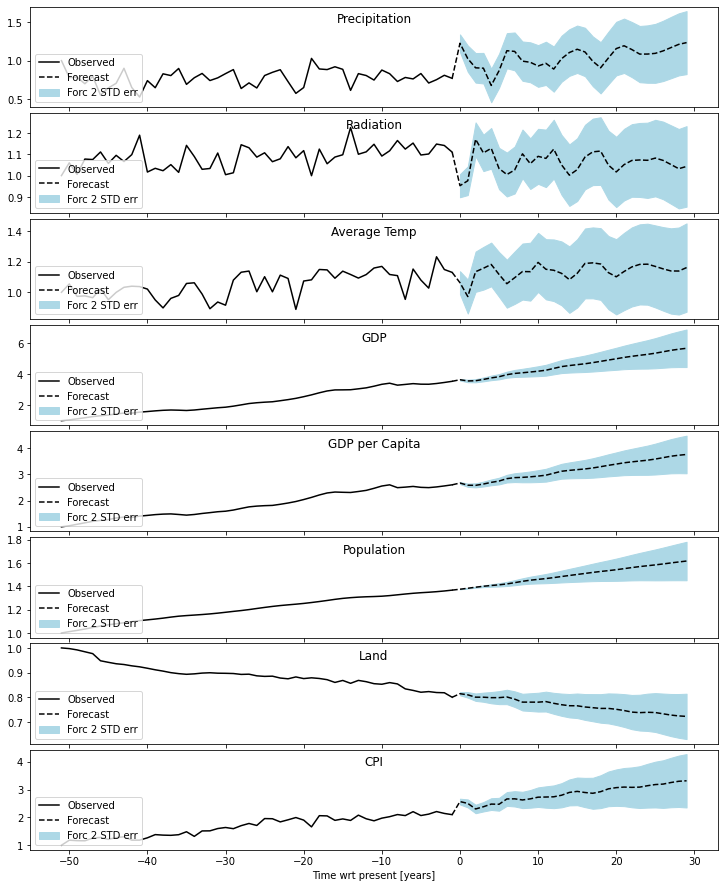

In [98]:
    
def plot_var_forc(prior, forc, err_upper, err_lower,ahead,
                  index=None, names=None, plot_stderr=True,
                  legend_options=None,norm=True):
    import matplotlib.pyplot as plt

    n, k = prior.shape
    rows, cols = k, 1

    

    prange = np.arange(n) -n
    rng_f = np.arange(n - 1, n + len(forc)) -n
    rng_err = np.arange(n, n + len(forc)) -n
    if norm:
        divide = prior[0]
        prior = prior/divide
        err_upper = err_upper/divide
        err_lower = err_lower/divide
        forc = forc/divide
    fig,axarr = plt.subplots(ncols=1,nrows=k,sharex=True,figsize=(10,12))
    for j in range(k):
        ax = axarr[j]#plt.subplot(rows, cols, j+1)

        p1 = ax.plot(prange, prior[:, j], 'k', label='Observed')
        p2 = ax.plot(rng_f, np.r_[prior[-1:, j], forc[:, j]], 'k--',
                     label='Forecast')

        if plot_stderr:
            p3 = ax.fill_between(rng_err, err_lower[:, j],err_upper[:, j],color='lightblue',
                         label='Forc 2 STD err')
            #ax.plot(rng_err, err_lower[:, j], 'k-.')

        if names is not None:
            ax.set_title(names[j],y=0.78)
        #ax.set_xlim(prange[0],prange[-1]+5)
        if legend_options is None:
            legend_options = {"loc": "upper right"}
        ax.legend(**legend_options)
    plt.tight_layout(pad=0.15)
    ax.set_xlabel('Time wrt present [years]')
    plt.savefig('VECM_prediction.pdf',bbox_inches='tight')
    return fig


predict_vecm('Netherlands')

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


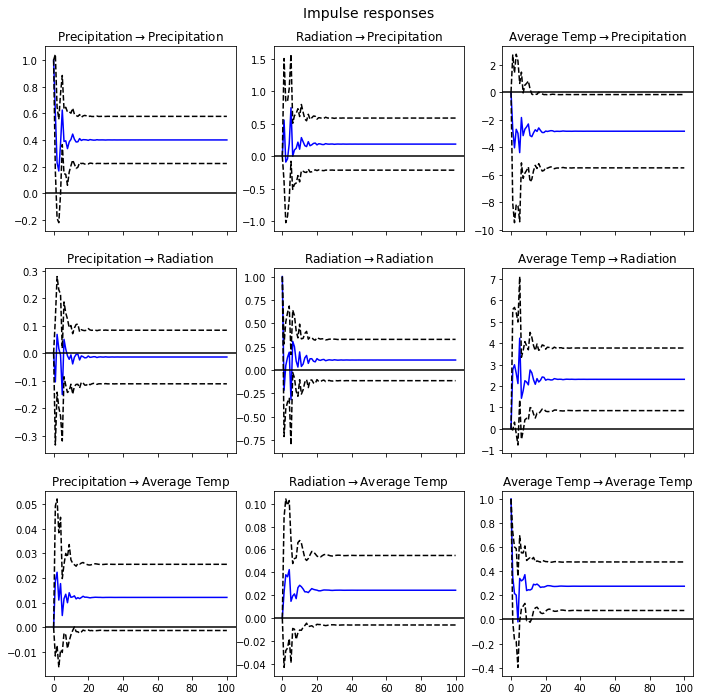

In [100]:
from statsmodels.compat.python import lrange
import statsmodels.tsa.vector_ar.util as util
def fit_vecm(land):
    estimate_vecm = VECM(endog = df.loc[land,['Precipitation', 'Radiation', 'Average Temp']].dropna(), k_ar_diff = 4, coint_rank = 1, deterministic = 'ci')
    estimate_vecm_fit = estimate_vecm.fit()
    estimate_vecm_fit.summary()
    return estimate_vecm_fit

def plot_irf(land):
    estimated_vecm = fit_vecm(land)
    irf = estimated_vecm.irf(100)
    plotter_irf(irf)
    
    
def plotter_irf(irf, orth=False, *, impulse=None, response=None,
             signif=0.05, plot_params=None, figsize=(10, 10),
             subplot_params=None, plot_stderr=True, stderr_type='asym',
             repl=1000, seed=None, component=None):
        """
        Plot impulse responses

        Parameters
        ----------
        orth : bool, default False
            Compute orthogonalized impulse responses
        impulse : {str, int}
            variable providing the impulse
        response : {str, int}
            variable affected by the impulse
        signif : float (0 < signif < 1)
            Significance level for error bars, defaults to 95% CI
        subplot_params : dict
            To pass to subplot plotting funcions. Example: if fonts are too big,
            pass {'fontsize' : 8} or some number to your taste.
        plot_params : dict

        figsize : (float, float), default (10, 10)
            Figure size (width, height in inches)
        plot_stderr : bool, default True
            Plot standard impulse response error bands
        stderr_type : str
            'asym': default, computes asymptotic standard errors
            'mc': monte carlo standard errors (use rpl)
        repl : int, default 1000
            Number of replications for Monte Carlo and Sims-Zha standard errors
        seed : int
            np.random.seed for Monte Carlo replications
        component: array or vector of principal component indices
        """
        periods = irf.periods
        model = irf.model
        svar = irf.svar

        if orth and svar:
            raise ValueError("For SVAR system, set orth=False")

        irfs = irf._choose_irfs(orth, svar)
        if orth:
            title = 'Impulse responses (orthogonalized)'
        elif svar:
            title = 'Impulse responses (structural)'
        else:
            title = 'Impulse responses'

        if plot_stderr is False:
            stderr = None

        elif stderr_type not in ['asym', 'mc', 'sz1', 'sz2','sz3']:
            raise ValueError("Error type must be either 'asym', 'mc','sz1','sz2', or 'sz3'")
        else:
            if stderr_type == 'asym':
                stderr = irf.cov(orth=orth)
            if stderr_type == 'mc':
                stderr = irf.errband_mc(orth=orth, svar=svar,
                                         repl=repl, signif=signif,
                                         seed=seed)
            if stderr_type == 'sz1':
                stderr = irf.err_band_sz1(orth=orth, svar=svar,
                                           repl=repl, signif=signif,
                                           seed=seed,
                                           component=component)
            if stderr_type == 'sz2':
                stderr = irf.err_band_sz2(orth=orth, svar=svar,
                                           repl=repl, signif=signif,
                                           seed=seed,
                                           component=component)
            if stderr_type == 'sz3':
                stderr = irf.err_band_sz3(orth=orth, svar=svar,
                                           repl=repl, signif=signif,
                                           seed=seed,
                                           component=component)

        fig = irf_grid_plot(irfs, stderr, impulse, response,
                                     irf.model.names, title, signif=signif,
                                     subplot_params=subplot_params,
                                     plot_params=plot_params,
                                     figsize=figsize,
                                     stderr_type=stderr_type)
        return fig
def _get_irf_plot_config(names, impcol, rescol):
    nrows = ncols = k = len(names)
    if impcol is not None and rescol is not None:
        # plot one impulse-response pair
        nrows = ncols = 1
        j = util.get_index(names, impcol)
        i = util.get_index(names, rescol)
        to_plot = [(j, i, 0, 0)]
    elif impcol is not None:
        # plot impacts of impulse in one variable
        ncols = 1
        j = util.get_index(names, impcol)
        to_plot = [(j, i, i, 0) for i in range(k)]
    elif rescol is not None:
        # plot only things having impact on particular variable
        ncols = 1
        i = util.get_index(names, rescol)
        to_plot = [(j, i, j, 0) for j in range(k)]
    else:
        # plot everything
        to_plot = [(j, i, i, j) for i in range(k) for j in range(k)]

    return nrows, ncols, to_plot
def adjust_subplots(**kwds):
    import matplotlib.pyplot as plt

    passed_kwds = dict(bottom=0.05, top=0.925,
                       left=0.05, right=0.95,
                       hspace=0.2)
    passed_kwds.update(kwds)
    plt.subplots_adjust(**passed_kwds)
    
def plot_with_error(y, error, x=None, axes=None, value_fmt='k',
                    error_fmt='k--', alpha=0.05, stderr_type = 'asym'):
    """
    Make plot with optional error bars
    Parameters
    ----------
    y :
    error : array or None
    """
    import matplotlib.pyplot as plt

    if axes is None:
        axes = plt.gca()

    x = x if x is not None else lrange(len(y))
    plot_action = lambda y, fmt: axes.plot(x, y, fmt)
    plot_action(y, value_fmt)

    #changed this
    if error is not None:
        if stderr_type == 'asym':
            q = util.norm_signif_level(alpha)
            plot_action(y - q * error, error_fmt)
            plot_action(y + q * error, error_fmt)
        if stderr_type in ('mc','sz1','sz2','sz3'):
            plot_action(error[0], error_fmt)
            plot_action(error[1], error_fmt)
            
def irf_grid_plot(values, stderr, impcol, rescol, names, title,
                  signif=0.05, hlines=None, subplot_params=None,
                  plot_params=None, figsize=(10,10), stderr_type='asym'):
    """
    Reusable function to make flexible grid plots of impulse responses and
    comulative effects
    values : (T + 1) x k x k
    stderr : T x k x k
    hlines : k x k
    """
    import matplotlib.pyplot as plt

    if subplot_params is None:
        subplot_params = {}
    if plot_params is None:
        plot_params = {}

    nrows, ncols, to_plot = _get_irf_plot_config(names, impcol, rescol)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True,
                             squeeze=False, figsize=figsize)

    # fill out space
    adjust_subplots()

    fig.suptitle(title, fontsize=14)

    subtitle_temp = r'%s$\rightarrow$%s'

    k = len(names)

    rng = lrange(len(values))
    for (j, i, ai, aj) in to_plot:
        ax = axes[ai][aj]

        # HACK?
        if stderr is not None:
            if stderr_type == 'asym':
                sig = np.sqrt(stderr[:, j * k + i, j * k + i])
                plot_with_error(values[:, i, j], sig, x=rng, axes=ax,
                                alpha=signif, value_fmt='b', stderr_type=stderr_type)
            if stderr_type in ('mc','sz1','sz2','sz3'):
                errs = stderr[0][:, i, j], stderr[1][:, i, j]
                plot_with_error(values[:, i, j], errs, x=rng, axes=ax,
                                alpha=signif, value_fmt='b', stderr_type=stderr_type)
        else:
            plot_with_error(values[:, i, j], None, x=rng, axes=ax,
                            value_fmt='b')

        ax.axhline(0, color='k')

        if hlines is not None:
            ax.axhline(hlines[i,j], color='k')

        sz = subplot_params.get('fontsize', 12)
        ax.set_title(subtitle_temp % (names[j], names[i]), fontsize=sz)

    return fig

plot_irf('Netherlands')

In [74]:
df.columns

Index(['Precipitation', 'Radiation', 'Average Temp', 'GDP', 'GDP per Capita',
       'Population', 'Land', 'CPI'],
      dtype='object')